In [45]:
from geodude.utils import Paper, merge_LineStrings, merge_Polygons
import vsketch
import numpy as np
from shapely.geometry import (
    box, 
    MultiLineString, 
    Point, 
    MultiPoint, 
    Polygon, 
    MultiPolygon, 
    LineString,
    )

from fn.fn import new_savepath
from geodude.ops import make_like
from shapely import is_valid, unary_union
import itertools
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from geodude.line import dash_linestring, bezier_func
from geodude.intersection import (
    pairwise_partition_polygons, 
    polys_to_gdf, 
    find_intersecting_polys,
    find_touching_polys, 
    find_clusters, 
    find_contained_polys, 
    find_parent_polygons,
    merge_disjoint_polys,
    assign_random_order_to_adjacent_clusters,
    assign_psuedoperiodic_order_to_adjacent_clusters,
    chunked_pairwise_partition_polygons
    )
from geodude.ops import buft_fill
from geodude.parameter import Prm, prms
from shapely.ops import nearest_points
from geodude.subdivide import split_poly, split_along_longest_side_of_min_rectangle, flex_rule_recursive_split, bino_draw
from functools import partial
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:

# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [207]:
phi = (1 + 5 ** 0.5) / 2
xgen = Prm(1/phi)

split_func = partial(split_along_longest_side_of_min_rectangle, xgen=xgen)

continue_func = partial(bino_draw, p_continue=0.85)

<Axes: >

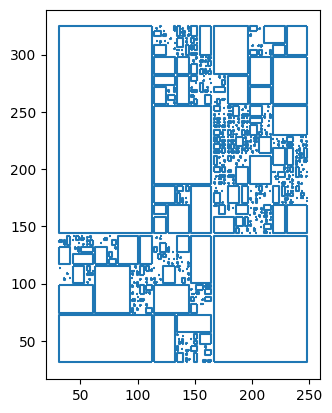

In [210]:
polys = flex_rule_recursive_split(poly=drawbox, split_func=split_func, continue_func=continue_func, depth=0, depth_limit=14)
gdf = gpd.GeoDataFrame(geometry=polys)

gdf.geometry = gdf.geometry.buffer(-1)
gdf = gdf[~gdf.geometry.is_empty]
gdf.boundary.plot()

In [82]:
drawbox.bounds

(30.0, 30.0, 249.39999999999998, 325.59999999999997)

In [211]:
effective_drawbox = box(*unary_union(gdf.geometry).bounds)

In [280]:
n_centers = 3
center_ys = np.linspace(100, 300, n_centers)
center_xs = np.linspace(60, 220, n_centers)
radii = np.random.uniform(75, 170, n_centers)
thickness = np.random.uniform(1, 7, n_centers)

circles = [Point(x, y).buffer(r, resolution=64) for x, y, r in zip(center_xs, center_ys, radii)]
rings = [c.boundary.buffer(thickness).intersection(effective_drawbox) for c, thickness in zip(circles, thickness)]

<Axes: >

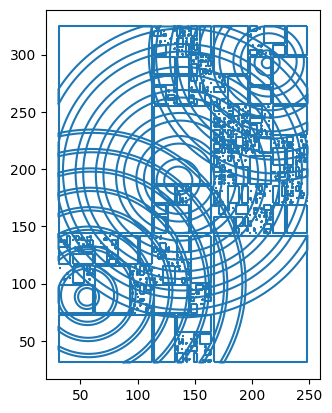

In [281]:
fills = []
for geom in circles:
    d_buffer = Prm(np.random.uniform(-20, -10))
    d_translate = Prm(lambda : d_buffer() * 0.1)
    deg = Prm(np.random.uniform(45, 90))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=100)
    fills.append(polys.boundary)
buffed_fills = [f.buffer(t).intersection(effective_drawbox) for f, t in zip(fills, thickness)]
combined = pd.concat([gdf, polys_to_gdf(buffed_fills)]).explode(index_parts=False).reset_index(drop=True)
combined.boundary.plot()

In [282]:
disjoint = chunked_pairwise_partition_polygons(
    combined, 
    chunk_size=10,
    min_area=1e-3,
    )

Iteration 1
Finding intersections in 531 polygons
970 intersections remaining
Chunking polygons
Partitioning 37 chunks


37it [00:00, 39.25it/s]


Iteration 1 complete, 603 polygons remaining
Iteration 2
Finding intersections in 603 polygons
1442 intersections remaining
Chunking polygons
Partitioning 56 chunks


56it [00:02, 22.15it/s]


Iteration 2 complete, 792 polygons remaining
Iteration 3
Finding intersections in 792 polygons
1060 intersections remaining
Chunking polygons
Partitioning 47 chunks


47it [00:02, 23.33it/s]


Iteration 3 complete, 673 polygons remaining
Iteration 4
Finding intersections in 673 polygons
736 intersections remaining
Chunking polygons
Partitioning 36 chunks


36it [00:01, 21.98it/s]


Iteration 4 complete, 537 polygons remaining
Iteration 5
Finding intersections in 537 polygons
436 intersections remaining
Chunking polygons
Partitioning 24 chunks


24it [00:00, 28.11it/s]


Iteration 5 complete, 322 polygons remaining
Iteration 6
Finding intersections in 322 polygons
276 intersections remaining
Chunking polygons
Partitioning 16 chunks


16it [00:00, 28.52it/s]


Iteration 6 complete, 217 polygons remaining
Iteration 7
Finding intersections in 217 polygons
166 intersections remaining
Chunking polygons
Partitioning 10 chunks


10it [00:00, 21.01it/s]


Iteration 7 complete, 128 polygons remaining
Iteration 8
Finding intersections in 128 polygons
76 intersections remaining
Chunking polygons
Partitioning 5 chunks


5it [00:00, 23.36it/s]


Iteration 8 complete, 64 polygons remaining
Iteration 9
Finding intersections in 64 polygons
34 intersections remaining
Chunking polygons
Partitioning 3 chunks


3it [00:00, 21.99it/s]


Iteration 9 complete, 27 polygons remaining
Iteration 10
Finding intersections in 27 polygons
8 intersections remaining
Chunking polygons
Partitioning 1 chunks


1it [00:00, 28.82it/s]

Iteration 10 complete, 11 polygons remaining
Iteration 11
Finding intersections in 11 polygons
0 intersections remaining
Chunking polygons


In [283]:

disjoint = find_parent_polygons(disjoint=disjoint, original=combined)
disjoint = assign_random_order_to_adjacent_clusters(disjoint)


In [284]:

ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

# clean up with closing + opening
buffer_value = 1e-2
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)


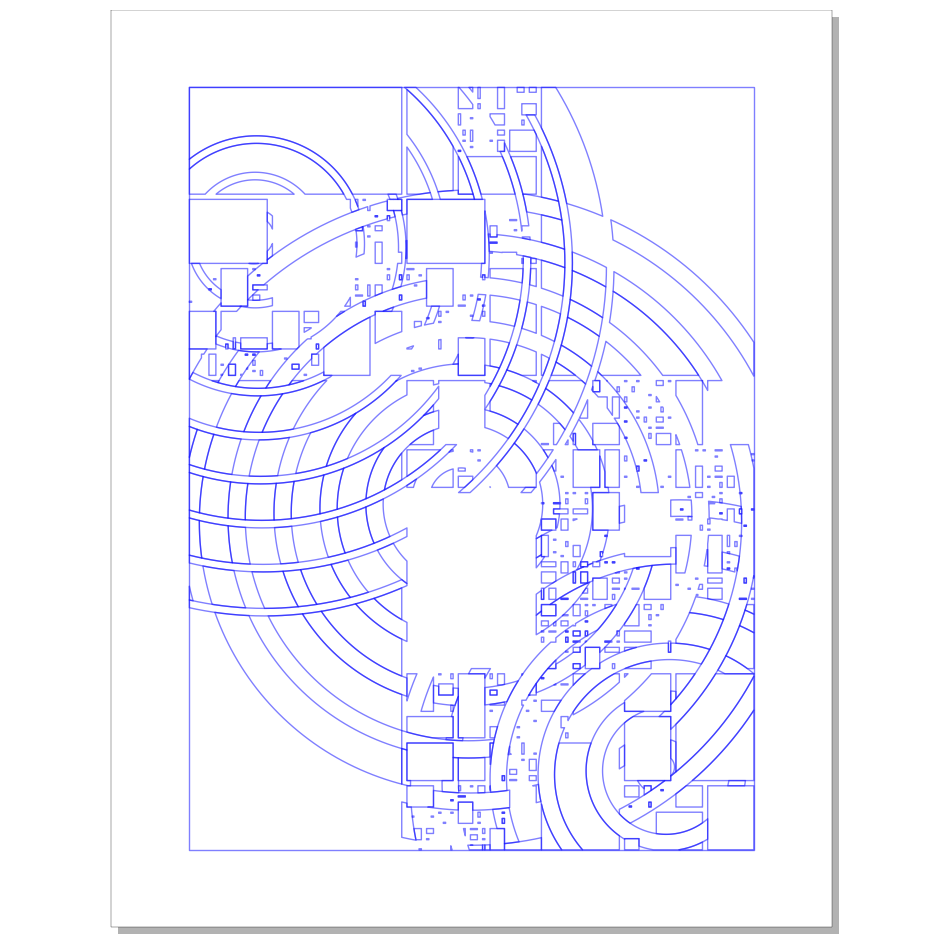

In [295]:

ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-9) & ~ngdf.is_empty
idx = idx & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.sample(frac=0.8, replace=False).geometry if p.boundary is not None]
mls = merge_LineStrings(lss + [effective_drawbox.boundary])


sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(mls, drawbox))
sk.display(fig_size=(12,12))


In [296]:
sk.vpype('splitall linemerge linesort')

In [297]:
fp = new_savepath(postfix='circles_and_subdivides')
sk.save(fp)

# with fills

In [298]:

# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [299]:
phi = (1 + 5 ** 0.5) / 2
xgen = Prm(1/phi)

split_func = partial(split_along_longest_side_of_min_rectangle, xgen=xgen)

continue_func = partial(bino_draw, p_continue=0.85)

<Axes: >

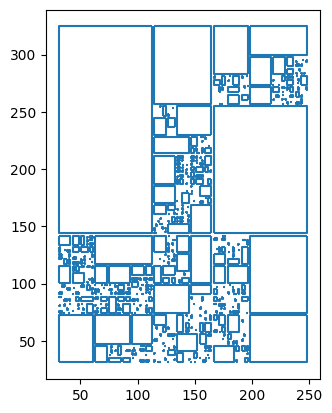

In [328]:
polys = flex_rule_recursive_split(poly=drawbox, split_func=split_func, continue_func=continue_func, depth=0, depth_limit=14)
gdf = gpd.GeoDataFrame(geometry=polys)

gdf.geometry = gdf.geometry.buffer(-1)
gdf = gdf[~gdf.geometry.is_empty]
gdf.boundary.plot()

In [329]:
effective_drawbox = box(*unary_union(gdf.geometry).bounds)

<Axes: >

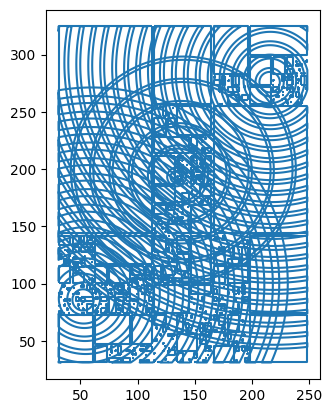

In [350]:
n_centers = 3
center_ys = np.linspace(100, 300, n_centers)
center_xs = np.linspace(60, 220, n_centers)
radii = np.random.uniform(75, 270, n_centers)
thickness = np.random.uniform(1, 5, n_centers)

circles = [Point(x, y).buffer(r, resolution=64) for x, y, r in zip(center_xs, center_ys, radii)]
rings = [c.boundary.buffer(thickness).intersection(effective_drawbox) for c, thickness in zip(circles, thickness)]
fills = []
for geom in circles:
    d_buffer = Prm(np.random.uniform(-20, -10))
    d_translate = Prm(lambda : d_buffer() * 0.1)
    deg = Prm(np.random.uniform(45, 90))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=100)
    fills.append(polys.boundary)
buffed_fills = [f.buffer(t).intersection(effective_drawbox) for f, t in zip(fills, thickness)]
combined = pd.concat([gdf, polys_to_gdf(buffed_fills).explode(index_parts=False)]).reset_index(drop=True)
combined.boundary.plot()

In [351]:
disjoint = chunked_pairwise_partition_polygons(
    combined, 
    chunk_size=10,
    min_area=1e-3,
    )

Iteration 1
Finding intersections in 519 polygons
2106 intersections remaining
Chunking polygons
Partitioning 44 chunks


44it [00:02, 20.43it/s]


Iteration 1 complete, 734 polygons remaining
Iteration 2
Finding intersections in 734 polygons
2580 intersections remaining
Chunking polygons
Partitioning 60 chunks


60it [00:03, 18.27it/s]


Iteration 2 complete, 1111 polygons remaining
Iteration 3
Finding intersections in 1111 polygons
2404 intersections remaining
Chunking polygons
Partitioning 75 chunks


75it [00:04, 18.28it/s]


Iteration 3 complete, 1277 polygons remaining
Iteration 4
Finding intersections in 1277 polygons
1964 intersections remaining
Chunking polygons
Partitioning 76 chunks


76it [00:04, 17.39it/s]


Iteration 4 complete, 1372 polygons remaining
Iteration 5
Finding intersections in 1372 polygons
1290 intersections remaining
Chunking polygons
Partitioning 64 chunks


64it [00:03, 18.57it/s]


Iteration 5 complete, 1055 polygons remaining
Iteration 6
Finding intersections in 1055 polygons
640 intersections remaining
Chunking polygons
Partitioning 38 chunks


38it [00:01, 20.25it/s]


Iteration 6 complete, 601 polygons remaining
Iteration 7
Finding intersections in 601 polygons
212 intersections remaining
Chunking polygons
Partitioning 14 chunks


14it [00:00, 25.83it/s]


Iteration 7 complete, 184 polygons remaining
Iteration 8
Finding intersections in 184 polygons
96 intersections remaining
Chunking polygons
Partitioning 7 chunks


7it [00:00, 21.67it/s]


Iteration 8 complete, 103 polygons remaining
Iteration 9
Finding intersections in 103 polygons
30 intersections remaining
Chunking polygons
Partitioning 3 chunks


3it [00:00, 35.73it/s]


Iteration 9 complete, 24 polygons remaining
Iteration 10
Finding intersections in 24 polygons
10 intersections remaining
Chunking polygons
Partitioning 1 chunks


1it [00:00, 17.37it/s]


Iteration 10 complete, 14 polygons remaining
Iteration 11
Finding intersections in 14 polygons
0 intersections remaining
Chunking polygons


In [352]:

disjoint = find_parent_polygons(disjoint=disjoint, original=combined)
disjoint = assign_random_order_to_adjacent_clusters(disjoint)


In [353]:

ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

# clean up with closing + opening
buffer_value = 1e-4
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)


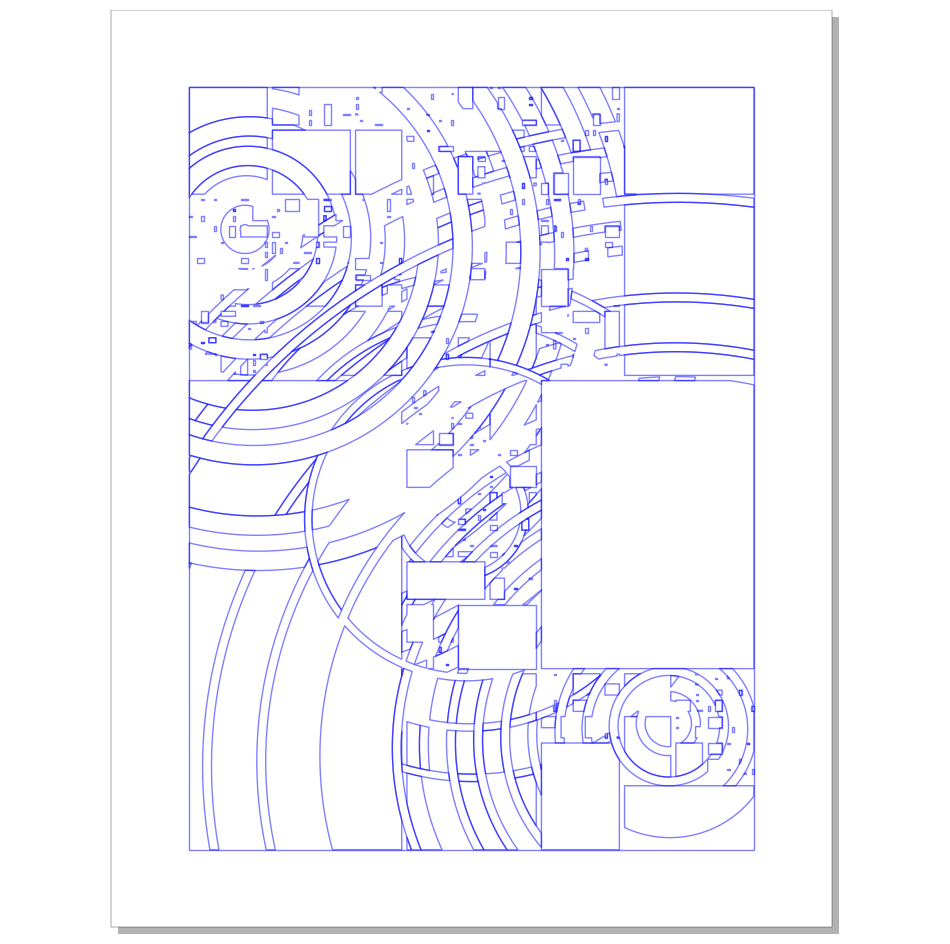

In [374]:

ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-9) & ~ngdf.is_empty
idx = idx & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.sample(frac=0.6, replace=False).geometry if p.boundary is not None]
mls = merge_LineStrings(lss + [effective_drawbox.boundary])


sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(mls, drawbox))
sk.display(fig_size=(12,12))


In [ ]:
sk.vpype('splitall linemerge linesort')

In [ ]:
fp = new_savepath(postfix='circles_and_subdivides')
sk.save(fp)

<Axes: >

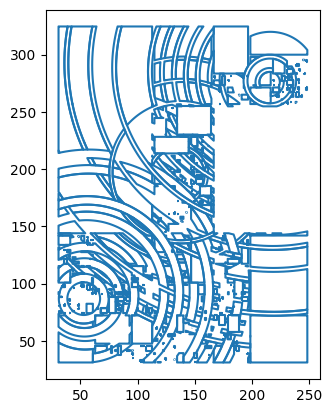

In [401]:
sampled_ngdf = ngdf.sample(frac=0.7, replace=False)
sampled_ngdf.boundary.plot()

In [402]:
fills = []
for geom in combined.geometry:
    d_buffer = Prm(np.random.uniform(-0.5, -0.1))
    d_translate = Prm(lambda : d_buffer() * np.random.uniform(0.1, 0.9))
    deg = Prm(np.random.uniform(15, 130))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=100)
    fills.append(polys.boundary)

In [403]:
fill_gdf = polys_to_gdf(fills)

In [404]:
masked = []

for ii, row in fill_gdf.iterrows():
    fill = row.geometry
    mask = sampled_ngdf.query('parent == @ii').geometry.buffer(1e-6)
    masked.append(fill.intersection(mask))
masked = pd.concat(masked)
masked = masked[~masked.is_empty]
fill_mls = merge_LineStrings(masked.to_list())

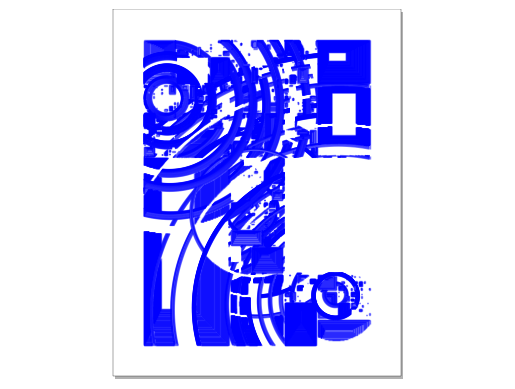

In [405]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(fill_mls, drawbox))
sk.display()

In [406]:
sk.vpype('splitall linemerge linesort')

In [407]:
fp = new_savepath(postfix='circles_and_subdivides_filled')
sk.save(fp)